In [34]:
import json                         # module pour load le file
import re                           # module pour retourner les hasthtags
from textblob import TextBlob       # module pour analyser le sentiment du tweet
import pandas as pd                 # module pour visualiser et comparer les tweets
import matplotlib.pyplot as plt     
from datetime import datetime
import random as rd             
import langid

# Data utilisé pour la création des dictionnaires pour faciliter l'analyse de diagramme,...
file = open("fichier_atterrissage.json","r")
data =json.load(file)
file.close()

# Data utilisé pour analyser visuellement les différentes caractéristiques d'un tweet
data2 = pd.read_json("fichier_atterrissage.json")
df_data = pd.DataFrame(data2)

In [35]:
class Tweet :
    def __init__(self,id_tweet,location_tweet,creation_tweet,retweet_count,tweet_language,tweet_text) :
        self.id = id_tweet
        self.location = location_tweet
        self.created = creation_tweet
        self.retweet = retweet_count
        self.language = tweet_language
        self.text = tweet_text
    
    def __str__(self):
        return f"Tweet id : {self.id}\nAuthor Location : {self.location} \nTweet Creation : {self.created} \nNumber of Retweets : {self.retweet} \nTweet Language : {self.language} \nTweet Text : {self.text}"
    
    def get_author(self):
        id_tweet = self.id
        return id_tweet
    
    def get_text(self):
        return self.text
    
    def get_hashtags(self):
        return re.findall(r"#(\w+)", self.text)

    def get_mention(self):
        return re.findall(r"@(\w+)", self.text)
    
    def get_sentiment(self):
        text = TextBlob(self.text)
        text_polarity = text.sentiment.polarity
        if text_polarity > 0 :
            return "Positive"
        elif text_polarity < 0 :
            return "Negative"
        else :
            return "Neutral" 


#instance/ objets de la class
tweets = [Tweet(tweet["id"],tweet["AuthorLocation"],tweet["CreatedAt"],tweet["RetweetCount"],tweet["TweetLanguage"],tweet["TweetText"]) for tweet in data]

In [36]:
#########################################################################################################################
##########################################  AVEC LES DICTIONNAIRES   ####################################################
#########################################################################################################################

# Pour Top K Hashtags -> 2 fonctions

# La première :
def all_hashtag():
    '''retourne tout les hashtags du fichier json dans une liste'''
    l = []                                         # on intialise la liste qui va être retournée à l'éxécution de la fonction
    for tweet in tweets:                           # on parcours tout les tweets (un par un)
        if tweet.get_hashtags()== [] :             # on vérifie avec l'atribut de l'instance si la valeur retourner est  "[]" <- pas de valeur ; dans ce cas là on passe au tweet suivant
            continue
        else :
            temp = tweet.get_hashtags()            # on affecte a temp (variable temporaire) la liste des hashtags de chaque tweet
            for hashtag in temp :                  # on accède à chaque hashtag présent dans temp
                l.append(hashtag)                  # on l'affecte à la liste finale qu'on va retourner
                
    return l
    
   
# La deuxième :
def top_hashtag(k):
    '''retourne le top k (index) hashtag utilisé dans la database'''
    hashtags = all_hashtag()                       # utilisation de la fonction all_hashtag() pour récupérer la liste complète des hashtag
    hashtag_count = {}                             # on initialise un dictionnaire vide pour compter chaque occurence de chaque hashtag
    for hashtag in hashtags :                      # ici on prend chaque hashtag un par un, ici nommé "e" (pour élément)
        if hashtag in hashtag_count :              # on vérifie si "hashtag" est dans le dictionnaire qui compte les occurences
            hashtag_count[hashtag] += 1            # dans ce cas là on incrémente sa valeur de 1
        else :
            hashtag_count[hashtag] = 1             # dans le cas contraire, on initialise la clé "hashtag" à une valeur initiale de 1 

    hashtag_count = dict(sorted(hashtag_count.items(),key = lambda x : x[1], reverse=True)) # on tri le dictionnaire en fonction des valeurs avec le lambda x[1] et reverse = True (de manière croissante)
    temp = list(hashtag_count.items())[:k]        # on converti le dictionnaire en une liste pour pouvoir effectué un slicing (afin d'obtenir les top k éléments) 
    top_k_hashtag = dict(temp)                    # on reconverti en dictionnaire afin de pouvoir manipuler les clés et valeurs facilement et dans un odre précis
    
    # Diagramme avec plt
    x_hashtag = list(top_k_hashtag.keys())        # on affecte à la variable x_hashtag les clés du dictionnaire (les hashtags (str))
    y_occurence = list(top_k_hashtag.values())    # on affecte à la variable y_occurence les valeurs des clés du dictionnaire (les occurences)

    plt.bar(x_hashtag,y_occurence)                # on créer le diagramme en bar avec en x -> x_hashtag et en y -> y_occurence
    plt.xlabel("Hashtag")                         # "Hashtag" comme titre de l'axe des x
    plt.ylabel("Occurence")                       # "Occurence" comme titre de l'axe des y

    plt.xticks(fontsize=6)                        # on précise la taille du texte pour les valeurs en x (les hashtags)
    plt.show()                                    # affichage du diagramme

    return top_k_hashtag                          # on retourne en même temps le dictionnaire trié en ordre croissant des top k hashtags

#########################################################################################################################

# Pour Top K Users -> 2 fonctions 

# La première : 
def all_users():
    '''retourne tout les utilisateurs présent dans le fichier json dans une liste'''
    l = []                                       # on intialise la liste qui va être retournée à l'éxécution de la fonction
    for tweet in tweets:                         # on parcours tout les tweets (un par un)
        user = tweet.get_author()                # on extrait l'auteur grâce à la méthode .get_author() qu'on place dans la variable user
        l.append(user)                           # on ajoute à la liste l'utilisateur/id du tweet
                
    return l

# La deuxième : 
def top_users(k):
    '''retourne le top k (index) d'utilisateurs/id présent dans la database'''
    users = all_users()                          # utilisation de la fonction all_users() pour récupérer la liste complète des utilisateurs
    user_ntweet = {}                             # on initialise un dictionnaire vide pour compter chaque occurence de chaque id
    for user in users :                          # ici on prend chaque id un par un, ici nommé "user"
        if user in user_ntweet :                 # on vérifie si l'id est déjà dans le dictionnaire
            user_ntweet[user] += 1               # si c'est le ce cas, on incrémente sa valeur de 1 
        else :
            user_ntweet[user] = 1                # sinon on crée une clé pour l'id correspondant et on initie sa valeur à 1 

    user_ntweet = dict(sorted(user_ntweet.items(), key = lambda x : x[1], reverse=True)) # on tri le dictionnaire en fonction des valeurs avec le lambda x[1] et reverse = True (de manière croissante)
    temp = list(user_ntweet.items())[:k]         # on converti le dictionnaire en une liste pour pouvoir effectué un slicing (afin d'obtenir les top k éléments)
    top_k_users = dict(temp)                     # on reconverti en dictionnaire afin de pouvoir manipuler les clés et valeurs facilement et dans un odre précis

    x_user = list(top_k_users.keys())            # on affecte à la variable x_user les clés du dictionnaire (les id (str))
    y_occurence = list(top_k_users.values())     # on affecte à la variable y_occurence les valeurs du dictionnaire (les occurences)

    plt.bar(x_user,y_occurence)                  # on créer le diagramme en bar avec en x -> x_hashtag et en y -> y_occurence
    plt.xlabel("User")                           # "User" comme titre de l'axe des x
    plt.ylabel("Occurence")                      # "Occurence" comme titre de l'axe des y

    plt.xticks(fontsize=5)                       # on précise la taille du texte pour les valeurs en x (les id)
    plt.show()                                   # affichage du diagramme

    return top_k_users                           # on retourne en même temps le dictionnaire trié en ordre croissant des top k users

#########################################################################################################################

# Pour the top K mentions -> 2 fonctions 

# La première : 
def all_mentions():
    '''retourne toutes les mentions de la database'''
    l = []                                        # on initialise la liste qui va être utilisée pour retourner les mentions à l'éxécution de la fonction
    for tweet in tweets:
        if tweet.get_mention()== [] :             # on vérifie avec l'atribut de l'instance si la valeur retourner est  "[]" <- pas de valeur ; dans ce cas là on passe au tweet suivant
            continue
        else :
            mentions = tweet.get_mention()        # on place les mentions obtenues du tweet dans la variable temporaire mentions (qui va correspondre à une liste) 
            for mention in mentions :             # on parcours chaque élément de la liste (ils peuvent être dans une liste de liste par exemple :[[mention],mention2,...])
                l.append(mention)                 # et on l'ajoute à notre liste finale
                
    return l

def top_mention(k):
    '''retourne le top k (index) d'utilisateurs/id présent dans la database'''
    mentions = all_mentions()                       # utilisation de la fonction all_mentions() pour récupérer la liste complète des mentions
    mention_ntweet = {}                             # on initialise un dictionnaire vide pour compter chaque occurence de chaque mention
    for mention in mentions :                       # ici on prend chaque mention, une par une
        if mention in mention_ntweet :              # on vérifie si la mention est présente dans le dictionnaire
            mention_ntweet[mention] += 1            # dans ce cas là on incrémente la valeur corresponde à la mention (la clé)
        else :
            mention_ntweet[mention] = 1             # dans le cas contraire on initie la clé correspondante à la mention à 1

    mention_ntweet = dict(sorted(mention_ntweet.items(),key = lambda x : x[1], reverse=True)) # on tri le dictionnaire en fonction des valeurs avec le lambda x[1] et reverse = True (de manière croissante)
    temp = list(mention_ntweet.items())[:k]         # on converti le dictionnaire en une liste pour pouvoir effectué un slicing (afin d'obtenir les top k éléments)
    top_k_mentions = dict(temp)                     # on reconverti la liste en dictionnaire trié en ordre croissant des top k mentions

    x_mention = list(top_k_mentions.keys())         # on affecte à la variable x_mention les clés du dictionnaire (les mentions (str))
    y_occurence = list(top_k_mentions.values())     # on affecte à la variable y_occurence les valeurs du dictionnaire (les occurences)

    plt.bar(x_mention,y_occurence)                  # on créer le diagramme en bar avec en x -> x_mention et en y -> y_occurence
    plt.xlabel("Mention",)                          # on créer le diagramme en bar avec en x -> x_mention
    plt.ylabel("Occurence")                         # on créer le diagramme en bar avec en y -> y_occurence

    plt.xticks(fontsize=7)                          # on précise la taille du texte pour les valeurs en x (les mentions)
    plt.show()                                      # affichage du diagramme

    return top_k_mentions                           # on retourne en même temps le dictionnaire trié en ordre croissant des top k mentions

#########################################################################################################################

def top_topics():
    pass


###########################################################################################################################
################################################## AVEC LES DATAFRAMES   ##################################################
###########################################################################################################################


def all_tweet_mention(mention):
    '''retourne l'ensemble des tweets mentionnant un utilisateur spécifique dans un dataframe'''                                                               
    return df_data[df_data["TweetText"].str.contains(f"@{mention}",regex=False)]              # on tri les lignes de la database pour extraire seulement celle qui contiennent @mention dans la colonne 

def all_tweet_hashtag(hashtag):
    '''retourne l'ensemble des tweets faisant référence à un hashtag spécifique'''                                                               
    return df_data[df_data["TweetText"].str.contains(f"#{hashtag}",regex=False)]              # on tri les lignes de la database pour extraire seulement celle qui contiennent #hashtag dans la colonne de TweetText

def user_specified_hashtag(hashtag):
    '''retourne les id de chaque utilisateur mentionnant un hashtag spécifique'''                                                         
    return df_data[df_data["TweetText"].str.contains(f"#{hashtag}",regex=True)].get("id")     # on tri les lignes de la database pour extraire  les #hashtag présent dans la colonne TweetText et on extrait seulement les id

def user_mentionned(user):
    '''retourne les utilisateurs mentionnés par un utilisateur spécifique'''                                                                
    text = str(df_data[df_data["id"]==user].get("TweetText"))                                 # on attribue à la variable text le texte du tweet qui correspond à l'utilisiateur spécifique
    return re.findall(r"@(\w+)", text)                                                        # on nettoie le text en extrayant les mentions avec le r"@(\w+)"



In [31]:
################################################# PARTIE SUR LA GESTION DES TWEETS #############################################################


def text_cleaning(text):
  '''retourne le texte entrée, nettoyer de tout symboles/emojis'''
  # Pattern trouvé sur le lien suivant : https://gist.github.com/Alex-Just/e86110836f3f93fe7932290526529cd1#gistcomment-3208085
  
  pattern = re.compile(
    "(["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "])"
                      )
  
  text = re.sub(pattern, r'', text)                  # ici l'expression regulière va supprimer (sub en anglais) les émojis et caractères contenus dans le pattern
  return text

def transfer(source, destination):
  '''retourne un "fichier_atterissage.json", une base de donnée nettoyer'''
  with open(source,"r") as source_file, open(destination,"w") as destination_file :       # on ouvre le fichier source (-> source_file) et fichier destination (-> destination_file)

      content_source = source_file.read()                        # on extrait le contenu de notre fichier source que l'on attribue à la variable content_source
      content_source = text_cleaning(content_source)             # 

      destination_file.write(content_source)

transfer("tweets.json","fichier_atterrissage.json")

In [32]:
################################################# PARTIE SUR LA CREATION DE TWEET #############################################################

def creation_time():
    '''retourne la date,heure, ... actuelle dans le format utilisé dans le base de donnée'''
    actual_time = datetime.now()                                          # on attribue la date actuelle à la variable actual_time 
    actual_time = actual_time.strftime("%Y-%m-%dT%H:%M:%SZ")              # on reformatise la date avec le format correspondant au fichier json, https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
    return actual_time

def random_location():
    '''retourner une ville aléatoire pour simuler la localisation de l'auteur du tweet'''                                                    
    locations =[                                                          # locations est une liste de Ville, Pays
                "Tokyo, Japan", 
                "New York City, United-States",
                "London, England",
                "Pekin, China",
                "Paris, France",
                "Montreal, Canada",
                "Madrid, Spain",
                "Los Angeles, United-States",
                "Delhi, India",
                "Beirut, Lebanon",
                "Versailles, France",
                "Amsterdam, Netherland",
                "Shanghai, China",
                "Moscou, Russia",
                "São Paulo, Brasil"
                ]
    
    return locations[rd.randint(0,len(locations)-1)]                     # on va retourner un ville aléatoire avec l'utilsation du module random (pour l'index)

def create_tweet():
    '''Fonction qui va permettre d'écrire un tweet et de l'intégrer dans la base de donnée'''  

    text_tweet = text_cleaning(input("Que voulez vous tweetez ?"))       # le sujet de notre tweet est récupérer dans la variable text_tweet
    tweet_lang,_ = langid.classify(text_tweet)                           # la langue est extraite de la variable text_tweet grace au module langid
    tweet = {                                                            # dictionnaire qui va contenir les informations sur le tweet
        "id": str(rd.randint(1000000000000000000,2000000000000000000)),       # on attribue un id aléatoire dans un interval semblable à celui de base
        "AuthorLocation": random_location(),
        "CreatedAt": creation_time() ,
        "RetweetCount": rd.randint(1,10),
        "TweetLanguage": tweet_lang,
        "TweetText": text_tweet                                           # à corriger pour les é etc on obtient /u... https://stackoverflow.com/questions/40412714/using-json-dumps-with-ensure-ascii-true
            }

    try:
        with open("fichier_atterrissage.json", "r") as file:
            database = json.load(file)
    except FileNotFoundError:
         
         database = []

    
    database.append(tweet)

    
    with open("fichier_atterrissage.json", "w") as file:
        json.dump(database, file,indent=3,ensure_ascii=False)            # sans le ensure ascii = False on aurait des \u... quand on mets des accents 

create_tweet()

In [7]:
############################################## TESTS ########################################################

In [41]:
tweets[-1].get_mention()

[]

In [33]:
all_hashtag()

['hdatasystems',
 'Artificia',
 'MachineLearning',
 'DataScience',
 'Python',
 'AI',
 '100DaysOfCode',
 'DEVCommunity',
 'IoT',
 'flutte',
 'artificialintelligence',
 'AI',
 'ArtificialIntelligence',
 'DeepLearning',
 'AI',
 'ArtificialIntelligence',
 'FEATURED',
 'COURSES',
 'machine',
 'learning',
 'FEATURED',
 'COURSES',
 'machine',
 'learning',
 'FEATURED',
 'COURSES',
 'machine',
 'learning',
 'data',
 'science',
 'Tensorflow',
 'artificial',
 'intelligence',
 'python',
 '100daysofcode',
 'coding',
 'udemy',
 'Artificial_Intelligence',
 'ai',
 'ml',
 'dl',
 'artificialintelligence',
 'Intela',
 'ArtificialIntelligence',
 'Ar',
 'ArtificialIntelligenc',
 'GovCloudWorldNews',
 'ArtificialIntelligence',
 'Java',
 'Bitcoin',
 'SciketLearn',
 'ComputerVision',
 'DeepLearningFramework',
 'AutonomousVehicles',
 'NFT',
 'ImageProcessing',
 'React',
 'LinearAlgebra',
 'Bluetooth',
 'AI',
 'Robotics',
 'Automation',
 'Ro',
 'Robotics',
 'Automation',
 'Ro',
 'ArtificialIntelligence',
 'REAL

In [43]:
all_tweet_hashtag("code")

,id,AuthorLocation,CreatedAt,RetweetCount,TweetLanguage,TweetText
361,1416470156910419968,,2021-07-17T18:49:36Z,58,en,RT @ALSALHAN: How to become a Full Stack Devel...
363,1416470166972608512,Jammu And Kashmir,2021-07-17T18:49:39Z,58,en,RT @ALSALHAN: How to become a Full Stack Devel...
653,1417602930216144896,"M, Venezuela",2021-07-20T21:50:51Z,47,en,RT @EntarchS: Artificial Intelligence - Techno...
1285,1419913494699278336,,2021-07-27T06:52:12Z,3,en,How to start learning programming\n\n Retweet ...
1707,1246773231948865536,"Beirut, Lebanon",2023-12-04T19:28:54Z,1,fr,Je teste mes fonctions sur le fichier d'atterr...


In [47]:
print(tweets[653])

Tweet id : 1417602930216144899
Author Location : M, Venezuela 
Tweet Creation : 2021-07-20T21:50:51Z 
Number of Retweets : 47 
Tweet Language : en 
Tweet Text : RT @EntarchS: Artificial Intelligence - Technology Landscape

#programming #coding #Python #Java #javascript #code #coder #100DaysOfCode #A…


In [11]:
user_mentionned(1418705513660010496)        # à corriger

['jfagone']

In [12]:
all_tweet_hashtag("MachineLearning")

,id,AuthorLocation,CreatedAt,RetweetCount,TweetLanguage,TweetText
3,1415291968700264448,Internet,2021-07-14T12:47:54Z,20,en,RT @HarbRimah: Making AI Sing https://t.co/FJo...
51,1415443187666141184,,2021-07-14T22:48:48Z,4,en,RT @Udemy_Coupons1: Artificial Intelligence (A...
52,1415443205995249664,Everywhere,2021-07-14T22:48:52Z,4,en,RT @Udemy_Coupons1: Artificial Intelligence (A...
121,1415654597964615680,,2021-07-15T12:48:52Z,7,en,RT @digitalkecom: The branches of Artificial I...
154,1415775469161652224,Europe,2021-07-15T20:49:10Z,37,en,RT @Paula_Piccard: Decoding crop genetics with...
...,...,...,...,...,...,...
1636,1421182351166558208,United Arab Emirates,2021-07-30T18:54:11Z,14,en,RT @bimedotcom: What is the Difference Between...
1637,1421182439897157632,,2021-07-30T18:54:32Z,14,en,RT @bimedotcom: What is the Difference Between...
1638,1421182364164796416,Switzerland,2021-07-30T18:54:14Z,14,en,RT @bimedotcom: What is the Difference Between...
1675,1421333417006931968,"Kyiv, Ukraine",2021-07-31T04:54:28Z,122,en,RT @Paula_Piccard: Artificial Intelligence len...


In [13]:
all_tweet_mention("nigewillson")

,id,AuthorLocation,CreatedAt,RetweetCount,TweetLanguage,TweetText
20,1415337411350040576,"Kyiv, Ukraine",2021-07-14T15:48:29Z,4,en,RT @nigewillson: Unleashing The Power Of A Div...
94,1415579078950735872,Mysore and BERLIN,2021-07-15T07:48:47Z,1,en,RT @nigewillson: Artificial intelligence will ...
96,1415579123028676608,Mysore and BERLIN,2021-07-15T07:48:57Z,3,en,RT @nigewillson: This Artificial Intelligence ...
459,1416787254278754304,U.K.,2021-07-18T15:49:38Z,9,en,RT @nigewillson: Artificial Intelligence desig...
498,1416983641880735744,"Kyiv, Ukraine",2021-07-19T04:50:01Z,27,en,RT @nigewillson: Artificial Intelligence desig...
699,1417753918558412800,"London, England",2021-07-21T07:50:49Z,2,en,RT @nigewillson: Why business and academia nee...
741,1417889895444619264,"Berlin, Deutschland",2021-07-21T16:51:08Z,2,en,RT @nigewillson: Time for a Robot CEO? With ad...
743,1417889877425807360,,2021-07-21T16:51:04Z,2,en,RT @nigewillson: Time for a Robot CEO? With ad...
758,1417935180426326016,Slovakia,2021-07-21T19:51:05Z,9,en,RT @nigewillson: An Artificial Intelligence an...
794,1418101303188852736,Switzerland,2021-07-22T06:51:12Z,8,en,RT @nigewillson: Future Artificial Intelligenc...


In [14]:
user_mentionned(1415291886860967936)

['pacorjo']

In [15]:
df_data

,id,AuthorLocation,CreatedAt,RetweetCount,TweetLanguage,TweetText
0,1415291947560828928,Mysore and BERLIN,2021-07-14T12:47:49Z,2,en,RT @HDataSystems: Artificial Intelligence and ...
1,1415291877897605120,,2021-07-14T12:47:33Z,246,en,RT @adgpi: Army Technology Board conducted the...
2,1415291886860967936,,2021-07-14T12:47:35Z,1,en,"RT @pacorjo: According to a recent survey, the..."
3,1415291968700264448,Internet,2021-07-14T12:47:54Z,20,en,RT @HarbRimah: Making AI Sing https://t.co/FJo...
4,1415292139941109760,,2021-07-14T12:48:35Z,1,en,RT @weblineglobal: The applications of #artifi...
...,...,...,...,...,...,...
1702,1421408743770791936,"Liverpool, England",2021-07-31T09:53:47Z,1,en,RT @innomaticshyd: Top 10 Real world Artificia...
1703,1421424066305605632,,2021-07-31T10:54:40Z,0,en,Iowa State part of U.S. National Science Found...
1704,1421423882427371520,127.0.0.1,2021-07-31T10:53:57Z,17,en,RT @intellimetri: Human Assisted #ArtificialIn...
1705,1421423971858149376,"Singapore, Singapore",2021-07-31T10:54:18Z,12,en,RT @IainLJBrown: Artificial Intelligence learn...


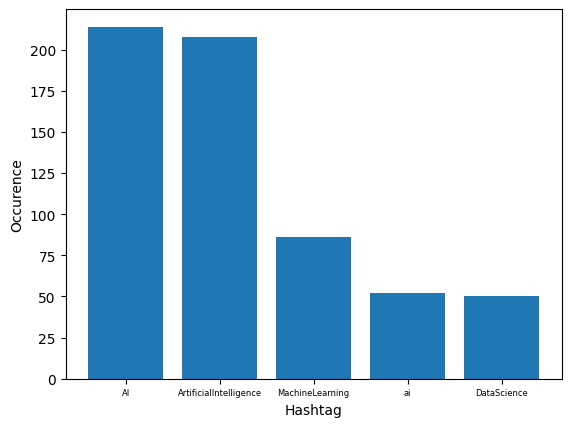

{'AI': 214,
 'ArtificialIntelligence': 208,
 'MachineLearning': 86,
 'ai': 52,
 'DataScience': 50}

In [16]:
top_hashtag(5)

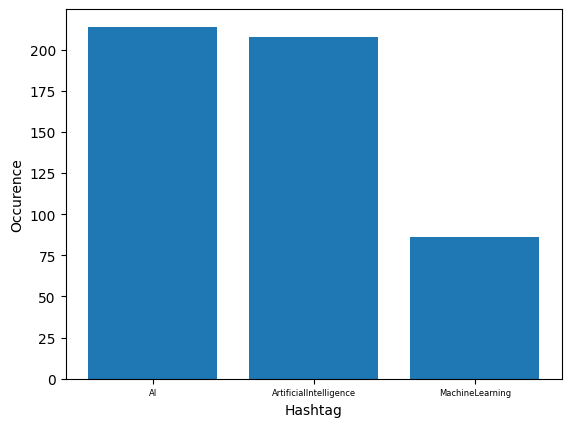

{'AI': 214, 'ArtificialIntelligence': 208, 'MachineLearning': 86}

In [17]:
# Test for Top k hashtags
all_hashtag()
top_hashtag(3)

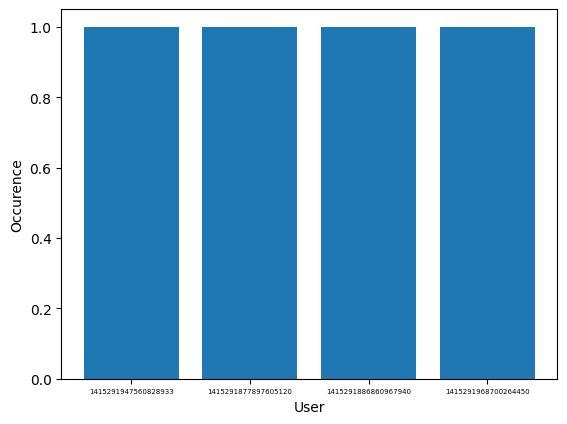

{'1415291947560828933': 1,
 '1415291877897605120': 1,
 '1415291886860967940': 1,
 '1415291968700264450': 1}

In [18]:
# Test for Top k users
all_users()
top_users(4)

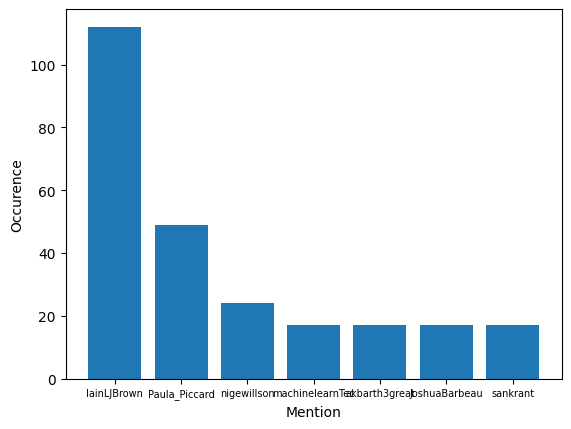

{'IainLJBrown': 112,
 'Paula_Piccard': 49,
 'nigewillson': 24,
 'machinelearnTec': 17,
 'akbarth3great': 17,
 'JoshuaBarbeau': 17,
 'sankrant': 17}

In [19]:
# Test for Top k mentions
all_mentions()
top_mention(7)

In [20]:
all_tweet_hashtag("DataScience")

,id,AuthorLocation,CreatedAt,RetweetCount,TweetLanguage,TweetText
3,1415291968700264448,Internet,2021-07-14T12:47:54Z,20,en,RT @HarbRimah: Making AI Sing https://t.co/FJo...
99,1415594177136668672,The Netherlands,2021-07-15T08:48:46Z,0,en,Employers turning to #ArtificialIntelligence t...
154,1415775469161652224,Europe,2021-07-15T20:49:10Z,37,en,RT @Paula_Piccard: Decoding crop genetics with...
253,1416122729066123264,The Netherlands,2021-07-16T19:49:03Z,1,en,A simple model of the brain provides new direc...
270,1416168124831895552,Germany,2021-07-16T22:49:26Z,167,en,RT @Paula_Piccard: 9 top applications of artif...
328,1416364411355385856,"Brighton & Hove, UK",2021-07-17T11:49:25Z,4,en,RT @Fisher85M: What are some Artificial Intell...
375,1416515546753929216,"Tallinn, Estonia",2021-07-17T21:49:58Z,307,en,RT @Paula_Piccard: Artificial Intelligence Cre...
377,1416515488000221184,Internet,2021-07-17T21:49:44Z,307,en,RT @Paula_Piccard: Artificial Intelligence Cre...
423,1416681648662269952,,2021-07-18T08:50:00Z,79,en,RT @machinelearnTec: Using artificial intellig...
424,1416681626311008256,Europe,2021-07-18T08:49:55Z,79,en,RT @machinelearnTec: Using artificial intellig...


In [21]:
all_tweet_mention("SpirosMargaris")

,id,AuthorLocation,CreatedAt,RetweetCount,TweetLanguage,TweetText
142,1415745098394996736,,2021-07-15T18:48:29Z,170,en,RT @DeepLearn007: Amazing #AI Translates Menta...
200,1415926488801718272,Kenya,2021-07-16T06:49:16Z,0,en,Why Global #ArtificialIntelligence \n\nis the ...
367,1416485301925539840,"Irvine, CA",2021-07-17T19:49:47Z,1,en,RT @SpirosMargaris: Researchers at @facebookai...
448,1416757077003931648,"Austin, TX",2021-07-18T13:49:43Z,2,en,RT @SpirosMargaris: What are the Implications ...
449,1416757074030174208,,2021-07-18T13:49:43Z,2,en,RT @SpirosMargaris: What are the Implications ...
457,1416787435535618048,U.K.,2021-07-18T15:50:21Z,12,en,RT @SpirosMargaris: What are the Implications ...
521,1417074345927745536,All Over the World,2021-07-19T10:50:26Z,4,en,RT @SpirosMargaris: Artificial Intelligence st...
943,1418614895818403840,"Dallas, TX",2021-07-23T16:52:02Z,0,en,As the presence of #AI and #automation increas...
1133,1419279456724791296,Northeast USA,2021-07-25T12:52:46Z,6,en,RT @SpirosMargaris: Good read\n\n#ArtificialIn...
1135,1419294395287982080,"Frankfurt on the Main, Germany",2021-07-25T13:52:07Z,25,en,RT @SpirosMargaris: What is #AI? \n\nEverythin...


In [22]:
df_data

,id,AuthorLocation,CreatedAt,RetweetCount,TweetLanguage,TweetText
0,1415291947560828928,Mysore and BERLIN,2021-07-14T12:47:49Z,2,en,RT @HDataSystems: Artificial Intelligence and ...
1,1415291877897605120,,2021-07-14T12:47:33Z,246,en,RT @adgpi: Army Technology Board conducted the...
2,1415291886860967936,,2021-07-14T12:47:35Z,1,en,"RT @pacorjo: According to a recent survey, the..."
3,1415291968700264448,Internet,2021-07-14T12:47:54Z,20,en,RT @HarbRimah: Making AI Sing https://t.co/FJo...
4,1415292139941109760,,2021-07-14T12:48:35Z,1,en,RT @weblineglobal: The applications of #artifi...
...,...,...,...,...,...,...
1702,1421408743770791936,"Liverpool, England",2021-07-31T09:53:47Z,1,en,RT @innomaticshyd: Top 10 Real world Artificia...
1703,1421424066305605632,,2021-07-31T10:54:40Z,0,en,Iowa State part of U.S. National Science Found...
1704,1421423882427371520,127.0.0.1,2021-07-31T10:53:57Z,17,en,RT @intellimetri: Human Assisted #ArtificialIn...
1705,1421423971858149376,"Singapore, Singapore",2021-07-31T10:54:18Z,12,en,RT @IainLJBrown: Artificial Intelligence learn...


In [23]:
all_hashtag()

['hdatasystems',
 'Artificia',
 'MachineLearning',
 'DataScience',
 'Python',
 'AI',
 '100DaysOfCode',
 'DEVCommunity',
 'IoT',
 'flutte',
 'artificialintelligence',
 'AI',
 'ArtificialIntelligence',
 'DeepLearning',
 'AI',
 'ArtificialIntelligence',
 'FEATURED',
 'COURSES',
 'machine',
 'learning',
 'FEATURED',
 'COURSES',
 'machine',
 'learning',
 'FEATURED',
 'COURSES',
 'machine',
 'learning',
 'data',
 'science',
 'Tensorflow',
 'artificial',
 'intelligence',
 'python',
 '100daysofcode',
 'coding',
 'udemy',
 'Artificial_Intelligence',
 'ai',
 'ml',
 'dl',
 'artificialintelligence',
 'Intela',
 'ArtificialIntelligence',
 'Ar',
 'ArtificialIntelligenc',
 'GovCloudWorldNews',
 'ArtificialIntelligence',
 'Java',
 'Bitcoin',
 'SciketLearn',
 'ComputerVision',
 'DeepLearningFramework',
 'AutonomousVehicles',
 'NFT',
 'ImageProcessing',
 'React',
 'LinearAlgebra',
 'Bluetooth',
 'AI',
 'Robotics',
 'Automation',
 'Ro',
 'Robotics',
 'Automation',
 'Ro',
 'ArtificialIntelligence',
 'REAL

In [24]:
user_specified_hashtag("FEATURED")

12      1415322365664321536
13      1415322360480141312
14      1415322343241617408
55      1415458235386056704
112     1415624374678433792
149     1415760317397835776
196     1415911392620781568
412     1416636248299503616
417     1416666595498160128
692     1417723632365748224
736     1417874814237282304
812     1418161717297565696
882     1418403376677593088
1266    1419837878478245888
1328    1420094844496711680
1466    1420608497855651840
1570    1420955799124389888
1648    1421212497319714816
1650    1421227543345045504
Name: id, dtype: int64

In [25]:
user_mentionned(1415291886860967936)

['pacorjo']

In [26]:
all_tweet_hashtag("machine")

,id,AuthorLocation,CreatedAt,RetweetCount,TweetLanguage,TweetText
12,1415322365664321536,Help us!,2021-07-14T14:48:42Z,4,en,RT @byLilyV: #FEATURED #COURSES\n\nMachine Lea...
13,1415322360480141312,Bot universe,2021-07-14T14:48:40Z,4,en,RT @byLilyV: #FEATURED #COURSES\n\nMachine Lea...
14,1415322343241617408,"Bradford, Yorkshire",2021-07-14T14:48:36Z,4,en,"#FEATURED #COURSES\n\nMachine Learning, Data S..."
147,1415760329229938688,Global,2021-07-15T19:49:00Z,0,en,Opening Up the Email Marketing Engine to Artif...
155,1415775356389318656,,2021-07-15T20:48:43Z,2,en,RT @MedicaliPhone: General News Article page #...
196,1415911392620781568,Earth,2021-07-16T05:49:17Z,6,en,RT @byLilyV: #FEATURED #COURSES\n\nMachine Lea...
300,1416273732809728000,,2021-07-17T05:49:05Z,3,en,RT @GreenTeamToad: $SSFT &gt;&gt; Logiq Levera...
330,1416364500480036864,,2021-07-17T11:49:46Z,2,en,RT @InstantConnect1: Artificial intelligence i...
388,1416545758405349376,,2021-07-17T23:50:01Z,0,en,The Future is Artificial Intelligence. There ...
417,1416666595498160128,"Jaipur, India",2021-07-18T07:50:11Z,18,en,RT @byLilyV: #FEATURED #COURSES\n\nMachine Lea...


In [27]:
tweets[0].get_author()

'1415291947560828933'

In [28]:
text_cleaning("Je m'appelle Ahmad, j'ai 19 et j'étudie l'informatique à l'Université de Versaille Saint-Quention en Yvelines 🎓")

"Je m'appelle Ahmad, j'ai 19 et j'étudie l'informatique à l'Université de Versaille Saint-Quention en Yvelines "